Нужно было использовать глубокий классификатор, заюзали ResNet, потому что эти residual connections позволяют глубокие сети обучать и проблему затухающих градиентов решать. 

Из-за величины размеров кадров, схожей структуры в разных местах среза и малого количества обучающих примеров решили нарезать. Для этого выбрали полностью сверточную сеть. Из-за того, что размер изображения стал маленький посмотрели в сторону соревнования CIFAR по классификации, там как раз снимки небольшого размера. На этом соревновании круто выступила модификация ResNet – Wide ResNet.  Там суть в том, что вместо углубления сети по количеству слоев её расширяют по количеству параметров при малом количестве слоев. Выбрали легкую сетку cifar wide renset 16. 16 значит, что у неё 16 слоев от натурально ResNet. К примеру чаще всего юзают обычный resnet 100. А у этой всего 16 слоев, но есть параметр k, который значит, во сколько раз у широкой сети больше параметров, чем у обычной ResNet. Официальная версия этой сети cifar_wiide_resnet_16_10. Мы её модифицировали с параметром 2. При этом уменьшение параметра ускорило модель и снизила вес параметро с 68 МБ до 2 МБ. Это было сделано, потому что у нас нет железа для обучения глубокой сети, а результаты у сеток вполне сходные, если датасет нормальный. А еще в задании указано, что мы должны сеть под задачу заточить. (но эту модификацию я просто один раз сделал и постоянно на работе юзаю). Еще для удобства встраивания докрутили Softmax выход у сети. Этого слоя не было в mxnet, пришлось дописать. Так что сетка сразу возвращает четкий выход в вероятностях (почти).

В рамках данного исследования эксперименты проводились на множестве изображений микросрезов образцов гелей содержащих различные добавки и полученных при разных температурных режимах. Каждый класс в данных множествах сформирован на основании использованных добавок(или без них) и температурного режима обработки.


(None, None)

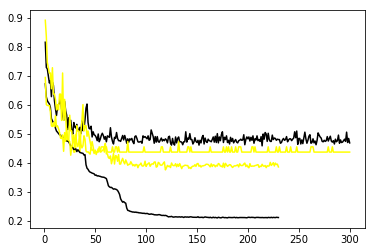

In [34]:
from matplotlib import pyplot as plt
import os as os
import numpy as np
import csv 

def load_run_viz(dataset_name):
    data = np.empty((0, 3))
    i = 0
    with open(dataset_name, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for train_error, val_error in reader:
            if train_error == "train-error":
                continue
            train_error = float(train_error)
            val_error = float(val_error)

            #           [index, train_error, val_error]
            i += 1
            data = np.append(data, np.array([[i, train_error, val_error]]), axis=0)

    plt.plot(data[:,0], data[:,1], c="black")
    plt.plot(data[:,0], data[:,2], c="yellow")
    
load_run_viz("res/big-pics/metrics.txt"), load_run_viz("res/lot-of-pics/metrics.txt")